In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size,run_i,rand_seed
0,uci wine example,Stan reading model,0.358266,0.359591,0.633725,inf,100,100,6497,6017,0,518677876
1,uci wine example,Stan utility model,0.388589,0.389704,0.797925,0.373698,100,100,6497,6017,0,518677876
2,uci wine example,logistic,0.405049,0.406714,0.787950,0.430940,100,100,6497,6017,0,518677876
3,uci wine example,observed score,0.500823,0.499834,0.626150,0.458113,100,100,6497,6017,0,518677876
4,uci wine example,Stan reading model,0.339943,0.336519,0.603975,inf,100,100,6497,6025,1,1451336747
...,...,...,...,...,...,...,...,...,...,...,...,...
75,uci wine example,observed score,0.522425,0.520198,0.647063,0.456487,100,100,6497,6015,18,566571108
76,uci wine example,Stan reading model,0.366933,0.366976,0.628425,0.471676,100,100,6497,6014,19,364254565
77,uci wine example,Stan utility model,0.372410,0.373151,0.768763,0.379785,100,100,6497,6014,19,364254565
78,uci wine example,logistic,0.367699,0.368227,0.755500,0.438858,100,100,6497,6014,19,364254565


In [3]:
n_draws = int(np.max(d['run_i']) + 1)

In [4]:
d_SpearmanR = d.melt(
    id_vars=['example_name', 'estimate_name'],
    value_vars=['SpearmanR_all', 'SpearmanR_test'],
    var_name='measurement',
    value_name='Spearman R',
)

d_SpearmanR

,example_name,estimate_name,measurement,Spearman R
0,uci wine example,Stan reading model,SpearmanR_all,0.358266
1,uci wine example,Stan utility model,SpearmanR_all,0.388589
2,uci wine example,logistic,SpearmanR_all,0.405049
3,uci wine example,observed score,SpearmanR_all,0.500823
4,uci wine example,Stan reading model,SpearmanR_all,0.339943
...,...,...,...,...
155,uci wine example,observed score,SpearmanR_test,0.520198
156,uci wine example,Stan reading model,SpearmanR_test,0.366976
157,uci wine example,Stan utility model,SpearmanR_test,0.373151
158,uci wine example,logistic,SpearmanR_test,0.368227


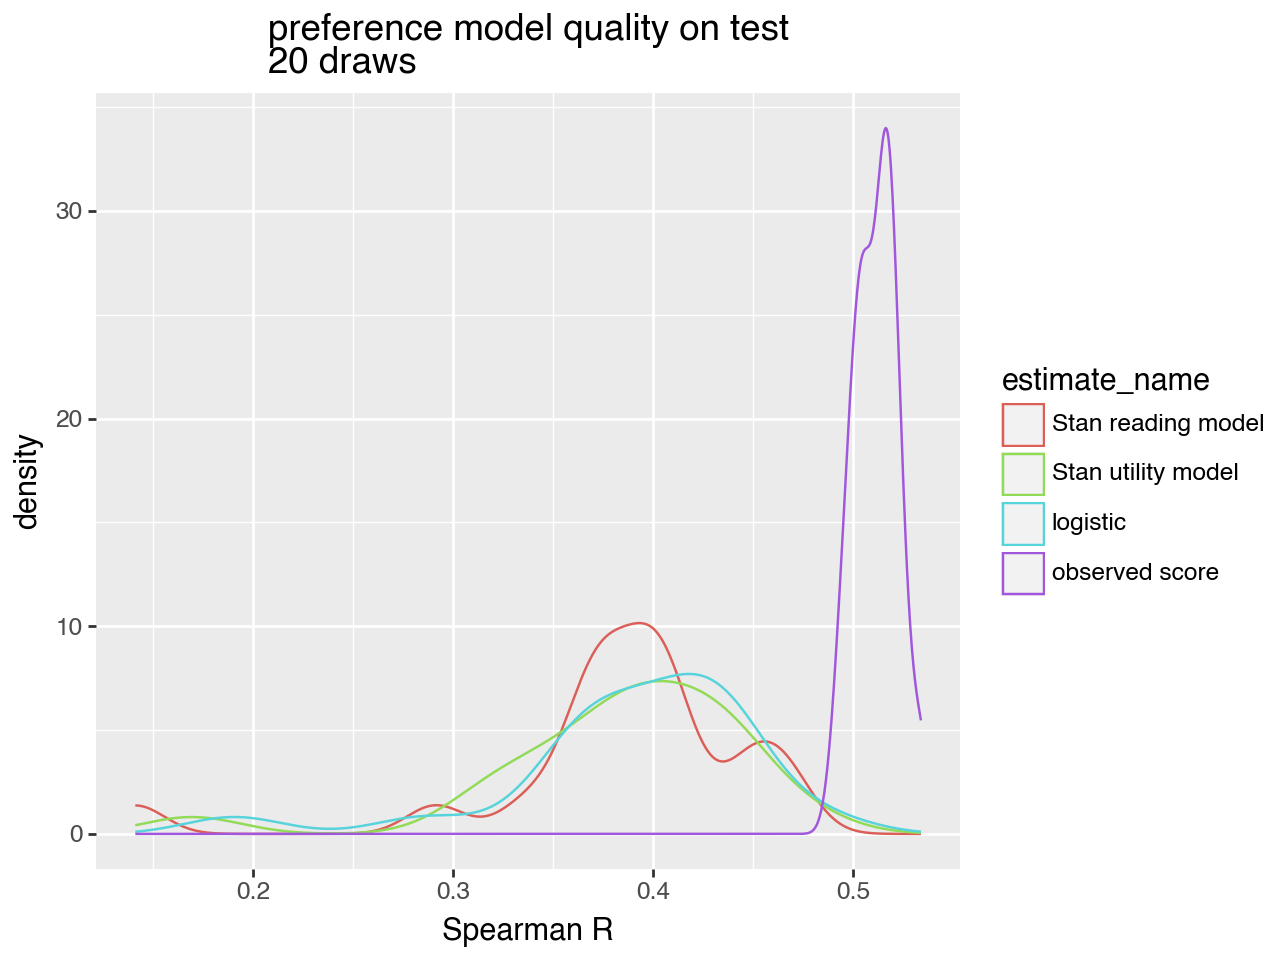

In [5]:
(
    ggplot(
        data=d_SpearmanR.loc[d_SpearmanR['measurement'] == 'SpearmanR_test', :],
        mapping=aes(
            x='Spearman R',
            color='estimate_name',
        )
    )
    + geom_density()
    + ggtitle(f"preference model quality on test\n{n_draws} draws")
)

In [6]:
estimate_names = sorted(set(d['estimate_name']))

estimate_names

['Stan reading model', 'Stan utility model', 'logistic', 'observed score']

Stan reading model


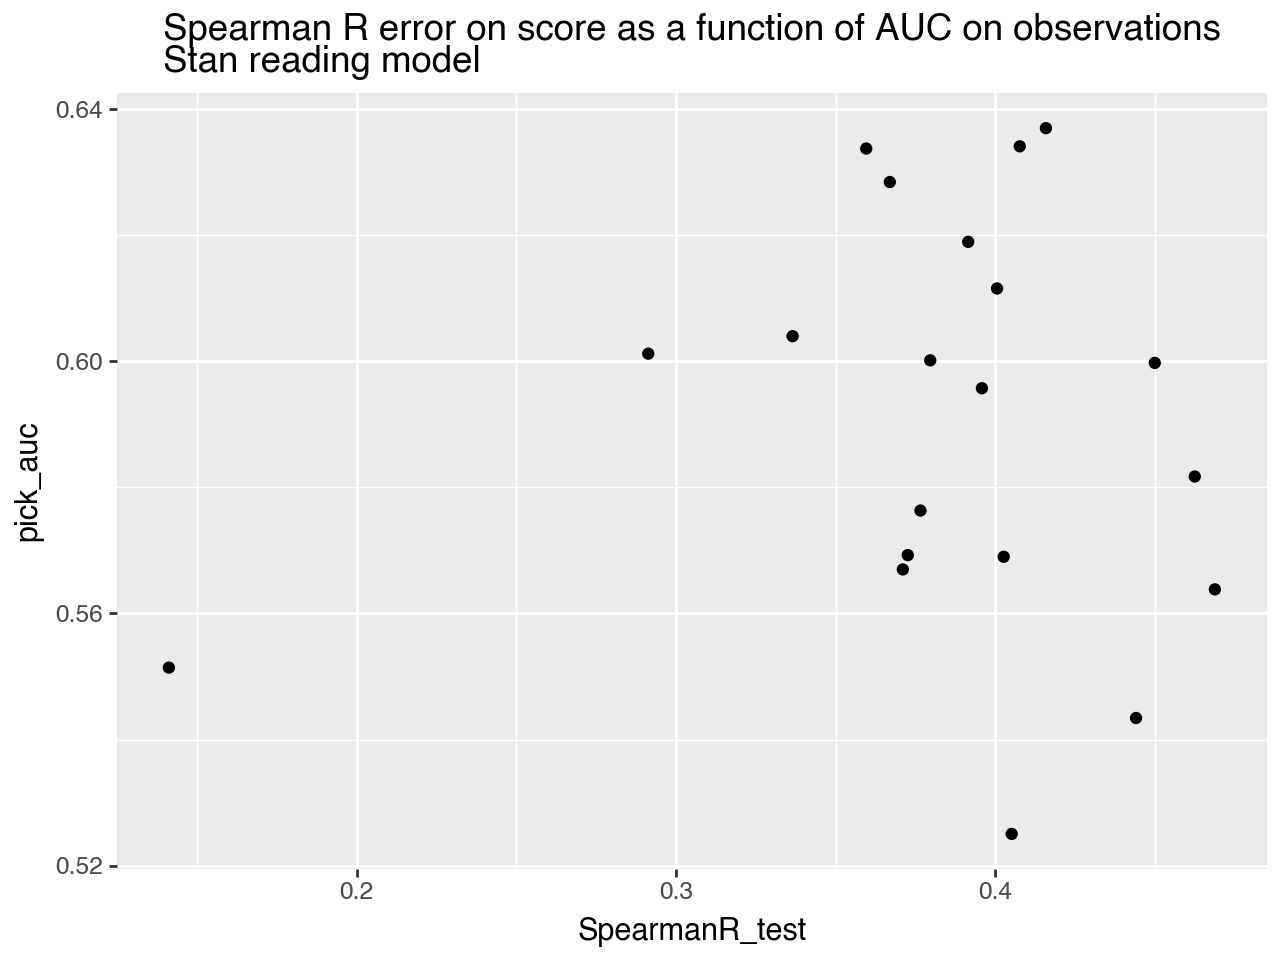

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                   0.08456
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.775
Time:                        13:22:14   Log-Likelihood:                 25.146
No. Observations:                  20   AIC:                            -46.29
Df Residuals:                      18   BIC:                            -44.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2930      0.306      0.956      0.352      -0.351       0.937
pick_auc       0.1506      0.518      0.291      0.775      -0.938       1.239
==============================================================================
Omnibus:                       20.506   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.654
Skew:                          -1.824   Prob(JB):                     1.63e-06
Kurtosis:                       7.321   Cond. No.                         43.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Stan utility model


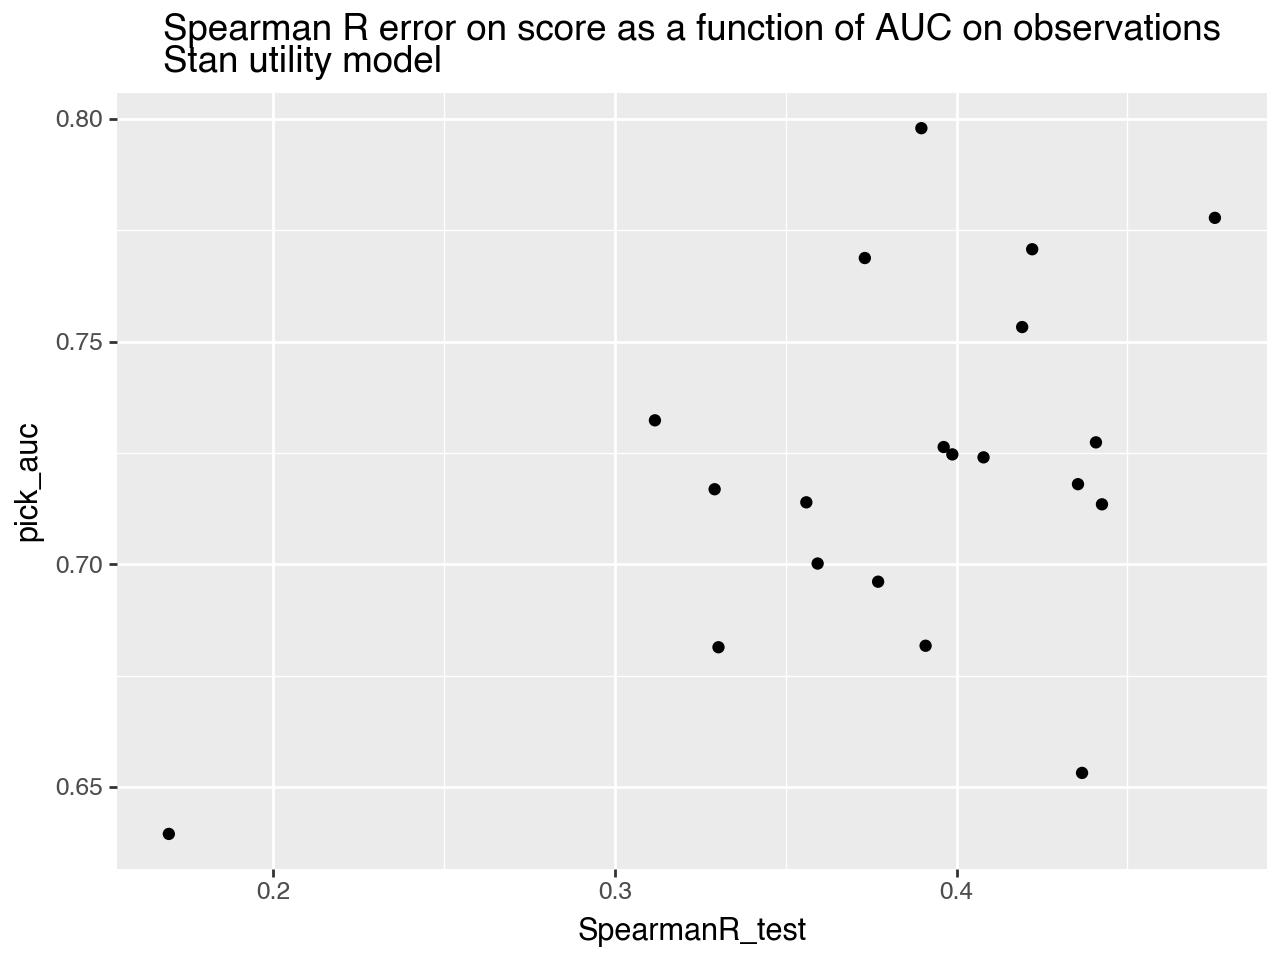

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     5.365
Date:                Wed, 28 Aug 2024   Prob (F-statistic):             0.0325
Time:                        13:22:15   Log-Likelihood:                 29.090
No. Observations:                  20   AIC:                            -54.18
Df Residuals:                      18   BIC:                            -52.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1843      0.245     -0.751      0.462      -0.700       0.331
pick_auc       0.7871      0.340      2.316      0.033       0.073       1.501
==============================================================================
Omnibus:                        3.417   Durbin-Watson:                   0.909
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                1.658
Skew:                          -0.635   Prob(JB):                        0.436
Kurtosis:                       3.613   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

logistic


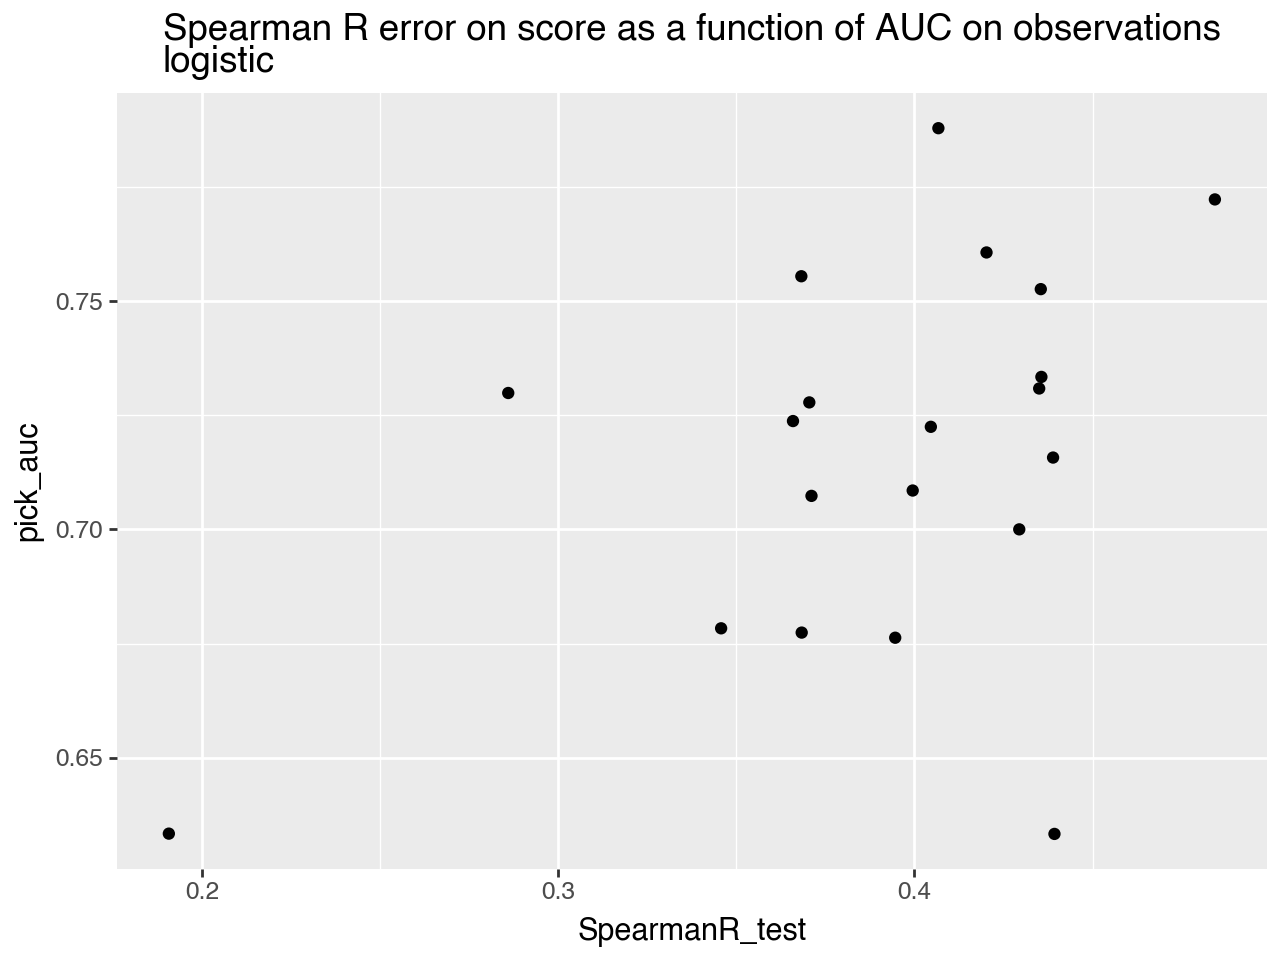

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     4.488
Date:                Wed, 28 Aug 2024   Prob (F-statistic):             0.0483
Time:                        13:22:15   Log-Likelihood:                 29.342
No. Observations:                  20   AIC:                            -54.68
Df Residuals:                      18   BIC:                            -52.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1037      0.233     -0.445      0.662      -0.593       0.386
pick_auc       0.6884      0.325      2.119      0.048       0.006       1.371
==============================================================================
Omnibus:                        4.596   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                2.491
Skew:                          -0.772   Prob(JB):                        0.288
Kurtosis:                       3.778   Cond. No.                         37.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

observed score


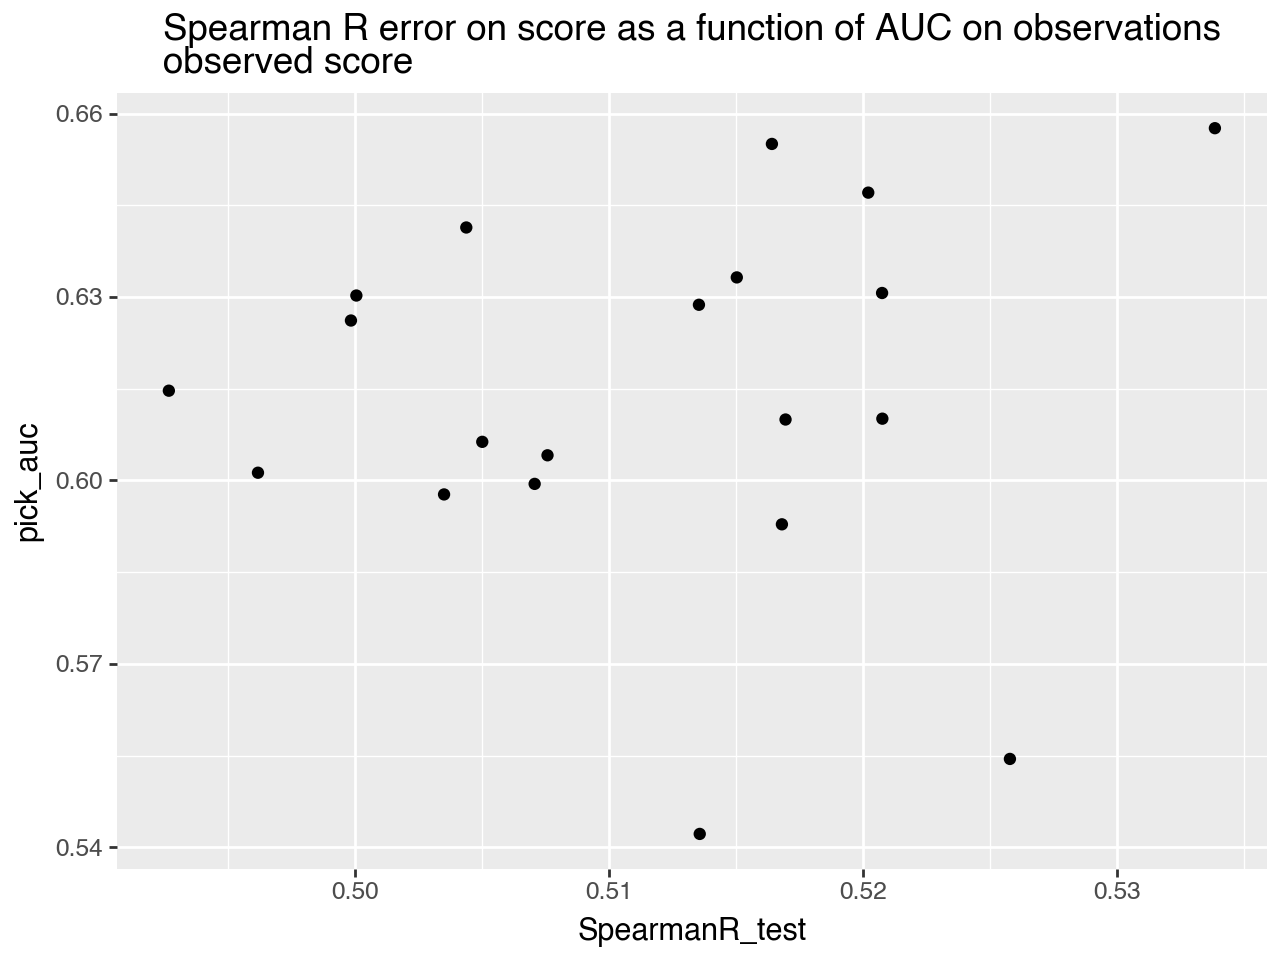

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.1240
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.729
Time:                        13:22:15   Log-Likelihood:                 63.299
No. Observations:                  20   AIC:                            -122.6
Df Residuals:                      18   BIC:                            -120.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4935      0.051      9.625      0.000       0.386       0.601
pick_auc       0.0294      0.083      0.352      0.729      -0.146       0.205
==============================================================================
Omnibus:                        0.163   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.376
Skew:                           0.060   Prob(JB):                        0.829
Kurtosis:                       2.339   Cond. No.                         47.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
for estimate_name in estimate_names:
    di = d.loc[d['estimate_name'] == estimate_name, :]
    print(estimate_name)
    (
        ggplot(
            data=di,
            mapping=aes(x='SpearmanR_test', y='pick_auc')
        )
        + geom_point()
        + ggtitle(f"Spearman R error on score as a function of AUC on observations\n{estimate_name}")
    ).show()
    model = ols(
        'SpearmanR_test ~ 1 + pick_auc',
        data=di,
    ).fit()
    display(model.summary())